In [48]:
import os
import sys
import json
import numpy as np
import pandas as pd
import numba as nb
import matplotlib.pyplot as plt
import opstrat as op
import datetime
import requests
import json
import pprint
from tqdm import tqdm
from scipy.stats import norm

pd.set_option('display.max_rows', 1000)

In [2]:
import yfinance as yf
import yfinance as yf
msft = yf.Ticker("^VIX")
vix = msft.history(period="6y")
vix.index = vix.index.astype('int64') // 10**9 - 18000
msft = yf.Ticker("^TNX")
tnx = msft.history(period="6y")
tnx.index = tnx.index.astype('int64') // 10**9 - 3600*4
msft = yf.Ticker("ES=F")
forward_prices = msft.history(period="6y")
forward_prices.index = forward_prices.index.astype('int64') // 10**9 

In [3]:
options_prices = pd.read_csv("./data/ES=F_opt_raw.csv")
options_prices['Date'] = pd.to_datetime(options_prices['Date'], format='%Y%m%d')
options_prices['Date'] = options_prices['Date'].apply(lambda x: x.timestamp())
options_prices['UnderlyingExp'] = pd.to_datetime(options_prices['UnderlyingExp'], format='%Y%m%d')
options_prices['UnderlyingExp'] = options_prices['UnderlyingExp'].apply(lambda x: x.timestamp())
options_prices['OptExp'] = pd.to_datetime(options_prices['OptExp'], format='%Y%m%d')
options_prices['OptExp'] = options_prices['OptExp'].apply(lambda x: x.timestamp())
options_prices = options_prices.astype({'Date': 'int64','UnderlyingExp': 'int64','OptExp': 'int64'})
options_prices.drop(columns = ['Underlying'], inplace=True)
options_prices = options_prices[options_prices.OptExp<=1684454400]
options_prices = options_prices[(options_prices.Bid+options_prices.Ask)!=0]
arr = options_prices["Strike"].values
arr[arr>9000]/=100
options_prices["Strike"] = arr
options_prices

,Date,UnderlyingExp,OptExp,Forward,Type,Style,Strike,Bid,Ask,IVRaw,IVInt,Delta,Gamma,Vega,Theta,Unnamed: 16
0,1496707200,1497571200,1496793600,2430.75,P,E,100.0,0.00,0.35,-1.000000,0.275049,0.000000,0.000000,0.000000,0.000000,NaN
1,1496707200,1497571200,1496793600,2430.75,P,E,500.0,0.00,0.35,-1.000000,0.275049,0.000000,0.000000,0.000000,0.000000,NaN
2,1496707200,1497571200,1496793600,2430.75,P,E,800.0,0.00,0.35,-1.000000,0.275049,0.000000,0.000000,0.000000,0.000000,NaN
3,1496707200,1497571200,1496793600,2430.75,P,E,825.0,0.00,0.35,-1.000000,0.275049,0.000000,0.000000,0.000000,0.000000,NaN
4,1496707200,1497571200,1496793600,2430.75,P,E,850.0,0.00,0.35,-1.000000,0.275049,0.000000,0.000000,0.000000,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8188751,1666915200,1686873600,1684454400,3978.00,C,E,5400.0,2.80,3.45,0.185762,0.185762,0.016306,0.000076,1.177011,-0.053464,NaN
8188752,1666915200,1686873600,1684454400,3978.00,C,E,5500.0,1.95,2.50,0.186218,0.186218,0.011806,0.000057,0.890953,-0.040615,NaN
8188753,1666915200,1686873600,1684454400,3978.00,C,E,5600.0,1.40,1.80,0.187206,0.187206,0.008662,0.000043,0.679999,-0.031188,NaN
8188754,1666915200,1686873600,1684454400,3978.00,C,E,5700.0,0.95,1.35,0.187814,0.187814,0.006245,0.000032,0.509701,-0.023430,NaN


In [4]:
# directory = "./data"
# files = os.listdir(directory)
# forward_prices = pd.DataFrame(columns=["timestamp", "close", "high", "low", "open", "idk"])
# for filename in files:
#     if filename.endswith(".txt"):
#         path_tmp = os.path.join(directory, filename)
#         df_tmp = None
#         with open(path_tmp) as f:
#                 df_tmp = pd.DataFrame([ map(np.float64, i[:-1].split(",")[1:]) for i in f ],columns=["close", "high", "low", "open", "idk"])
#         with open(path_tmp) as f:
#             arr = np.array(list(datetime.datetime.timestamp(datetime.datetime.strptime(i[:-1].split(",")[0],  "%Y-%m-%d %H:%M:%S")) for i in f))
#             df_tmp["timestamp"] = arr.astype('int64')
#             forward_prices = pd.concat((forward_prices, df_tmp))
# # forward_prices.astype({'timestamp': 'datetime64[s]'})
# forward_prices.set_index("timestamp", inplace = True)
# forward_prices.sort_index(inplace=True)
# forward_prices

In [8]:
opt_date_index1 = options_prices.Date.values
vix_index2 = vix.index.values
vix_closest_index = np.searchsorted(vix_index2, opt_date_index1, side='right') - 1
vix_closest_index

array([  10,   10,   10, ..., 1370, 1370, 1370])

In [9]:
opt_date_index1 = options_prices.Date.values
tnx_index2 = tnx.index.values
tnx_closest_index = np.searchsorted(tnx_index2, opt_date_index1, side='right') - 1
tnx_closest_index

array([  10,   10,   10, ..., 1370, 1370, 1370])

In [10]:
index1 = options_prices.OptExp.values
index2 = forward_prices.index.values
exp_closest_index = np.searchsorted(index2, index1, side='right') - 1
exp_closest_index
arr = (forward_prices.Close.iloc[exp_closest_index].values - options_prices.Strike.values)*(options_prices.Type=="C")
arr[arr < 0] = 0
arr2 = (-forward_prices.Close.iloc[exp_closest_index].values + options_prices.Strike.values)*(options_prices.Type=="P")
arr2[arr2 < 0 ] = 0
exp_opt_value = (arr+arr2).values

In [11]:
def black_scholes(t=40, r=4.00, v=32.00, K=60, St=62, type='c'):
    """
    Parameters:
    K : Excercise Price
    St: Current Stock Price
    v : Volatility in percentage
    r : Risk free rate in percentage
    t : Time to expiration in days
    type: Type of option 'c' for call 'p' for put
    default: 'c'
    """
    if(type=='C'):
        option_type='call'
    else:
        option_type='put'
    t=t/365
    r=r/100
    v=v/100
    n1=np.log(St/K)
    n2=(r+(np.power(v,2)/2))*t
    d=v*(np.sqrt(t))
    d1=(n1+n2)/d
    d2=d1-(v*np.sqrt(t))
    if type=='C':
        N_d1=norm.cdf(d1)
        N_d2=norm.cdf(d2)
    else:
        N_d1=norm.cdf(-d1)
        N_d2=norm.cdf(-d2)

    A=(St*N_d1)
    B=(K*N_d2*(np.exp(-r*t)))
    if type=='C':
        val=A-B
        val_int=max(0,St-K)
    else:
        val=B-A
        val_int=max(0,K-St)
    return val

In [12]:
# @nb.njit()
def get_proba(r, sigma, M):
    beta = 0.5*(np.exp(-r/M) + np.exp((r + sigma**2)/M))
    u = beta + np.sqrt(beta**2 - 1)
    d = 1 / u
    return u, (np.exp(r / M) - d) / (u - d)

# @nb.njit()
def price_mature_call(S_0, K, u, M):
    d = 1 / u
    S_M = np.zeros((M + 1,), dtype=np.float64)
    for j in range(M + 1):
        S_M[j] = S_0 * (u ** j) * (d ** (M - j))
    return np.maximum(S_M - K, 0)

# @nb.njit()
def price_mature_put(S_0, K, u, M):
    d = 1 / u
    S_M = np.zeros((M + 1,), dtype=np.float64)
    for j in range(M + 1):
        S_M[j] = S_0 * (u ** j) * (d ** (M - j))
    return np.maximum(K - S_M, 0)

# @nb.njit()
def price_previous_layer(r, M, p, current_layer):
    return np.exp(- r / M) * (p * current_layer[1:] + (1 - p) * current_layer[:-1])

# @nb.njit()
def price_european_call(S_0, K, sigma, r, M):
    u, p = get_proba(r, sigma, M)
    current_layer = price_mature_call(S_0, K, u, M)
    for layer in range(M):
        current_layer = price_previous_layer(r, M, p, current_layer)
    return current_layer[0]

# @nb.njit()
def price_european_put(S_0, K, sigma, r, M):
    u, p = get_proba(r, sigma, M)
    current_layer = price_mature_put(S_0, K, u, M)
    for layer in range(M):
        current_layer = price_previous_layer(r, M, p, current_layer)
    return current_layer[0]



# @nb.njit()
def get_maturity_underlying(S_0, K, u, M):
    d = 1/u
    S_M = np.zeros((M+1,1), dtype=np.float64)
    for j in range(M + 1):
        S_M[j] = S_0 * (u ** j) * (d ** (M - j))
    return S_M

# @nb.njit()
def price_american_put(S_0, K, sigma, r, M):
    u, p = get_proba(r, sigma, M)
    current_underlying = get_maturity_underlying(S_0, K, u, M)
    current_layer = np.maximum(K - current_underlying, 0)
    for layer in range(M):
        continuation_value = price_previous_layer(r, M, p, current_layer)
        current_underlying = current_underlying[:-1] * u
        intrinsic_value = np.maximum(K - current_underlying, 0)
        current_layer = np.maximum(intrinsic_value, continuation_value)
    return current_layer[0]+0.0

# @nb.njit()
def price_american_call(S_0, K, sigma, r, M):
    u, p = get_proba(r, sigma, M)
    current_underlying = get_maturity_underlying(S_0, K, u, M)
    current_layer = np.maximum(current_underlying - K, 0)
    for layer in range(M):
        continuation_value = price_previous_layer(r, M, p, current_layer)
        current_underlying = current_underlying[:-1] * u
        intrinsic_value = np.maximum(current_underlying - K, 0)
        current_layer = np.maximum(intrinsic_value, continuation_value)
    return current_layer[0]+0.0


In [65]:
# @nb.njit()
def compute_options_prices(opt_dates,strikes, forwards, opt_exp, types,  vix_closest_index, tnx_closest_index):
    arr = []
    volat = forward_prices.Closeвол.rolling(14).std().values
    for index_, i in tqdm((enumerate(opt_dates))):
        K = strikes[index_]
        St = forwards[index_]
        t = (opt_exp[index_] - i)/60/60/24
        opt_type = types[index_]
        vol = volat[tnx_closest_index[index_]]
        r = tnx.Open.values[tnx_closest_index[index_]]
        bsm=black_scholes(K=K, St=St, r=r, t=t, 
                         v=vol, type=opt_type)
        arr.append(bsm)
    return arr

In [57]:
opt_prices_b_s_10 = compute_options_prices(options_prices.Date.values,options_prices.Strike.values,options_prices.Forward.values, options_prices.OptExp.values, 
                       list(options_prices.Type.values), vix_closest_index, tnx_closest_index )

7792131it [23:05, 5622.19it/s]


In [59]:
opt_prices_b_s_25 = compute_options_prices(options_prices.Date.values,options_prices.Strike.values,options_prices.Forward.values, options_prices.OptExp.values, 
                       list(options_prices.Type.values), vix_closest_index, tnx_closest_index )

7792131it [23:08, 5610.75it/s]


In [63]:
opt_prices_b_s_vix = compute_options_prices(options_prices.Date.values,options_prices.Strike.values,options_prices.Forward.values, options_prices.OptExp.values, 
                       list(options_prices.Type.values), vix_closest_index, tnx_closest_index )

7792131it [23:43, 5474.16it/s]


In [67]:
opt_prices_b_s_std = compute_options_prices(options_prices.Date.values,options_prices.Strike.values,options_prices.Forward.values, options_prices.OptExp.values, 
                       list(options_prices.Type.values), vix_closest_index, tnx_closest_index )

7792131it [23:08, 5610.06it/s]


In [68]:
signals_b_s_10 = ((opt_prices_b_s_10>options_prices.Ask)*1-1* (opt_prices_b_s_10<options_prices.Bid)).values
signals_b_s_25 = ((opt_prices_b_s_25>options_prices.Ask)*1-1* (opt_prices_b_s_25<options_prices.Bid)).values
signals_b_s_vix = ((opt_prices_b_s_vix>options_prices.Ask)*1-1* (opt_prices_b_s_vix<options_prices.Bid)).values
signals_b_s_std = ((opt_prices_b_s_std>options_prices.Ask)*1-1* (opt_prices_b_s_std<options_prices.Bid)).values
# signals_binomial = ((opt_prices_binomial>options_prices.Ask)*1-1* (opt_prices_binomial<options_prices.Bid)).values
# signals_b_s[signals_b_s!=-1] = -1

In [44]:
# pnl_array = np.zeros(vix.shape[0]+1)
# trade_value = []
# for i in tqdm(range(options_prices.shape[0])):
#     value = 0
#     if signals[i]>0:
#         value = exp_opt_value[i] - options_prices.Ask.values[i]
# #     elif signals[i]<0:
# #         value =  options_prices.Bid.values[i] - exp_opt_value[i]
#     trade_value.append(value)
#     days_to_expire = (options_prices.OptExp.values[i] - options_prices.Date.values[i])/24/3600
#     pnl_array[tnx_closest_index[i]:exp_closest_index[i]+1] +=value/days_to_expire
# pnl_array

In [49]:
@nb.njit()
def run_backtest(signals, ask_prices, bid_prices, opt_exp, opt_date, opt_date_closest_index,exp_closest_index):
    pnl_array = np.zeros((exp_closest_index[-1]-1- opt_date_closest_index[0],), dtype = np.float64)
    trade_value = []
    for i in (range(len(signals))):
        value = 0
        if signals[i]>0:
            value = exp_opt_value[i] -ask_prices[i]
        elif signals[i]<0:
            value =  bid_prices[i] - exp_opt_value[i]
        trade_value.append(value)
        days_to_expire = (opt_exp[i] - opt_date[i])/24/3600
        pnl_array[opt_date_closest_index[i] - opt_date_closest_index[0]:exp_closest_index[i]- opt_date_closest_index[0]] +=value/days_to_expire
    return pnl_array.cumsum(), np.array(trade_value)

def calc_sharpe(pnl):
    ret = pnl[1:] - pnl[:-1]
    if np.std(ret) < 1e-8:
        return 0
    return np.mean(ret) / np.std(ret) * np.sqrt(len(pnl))


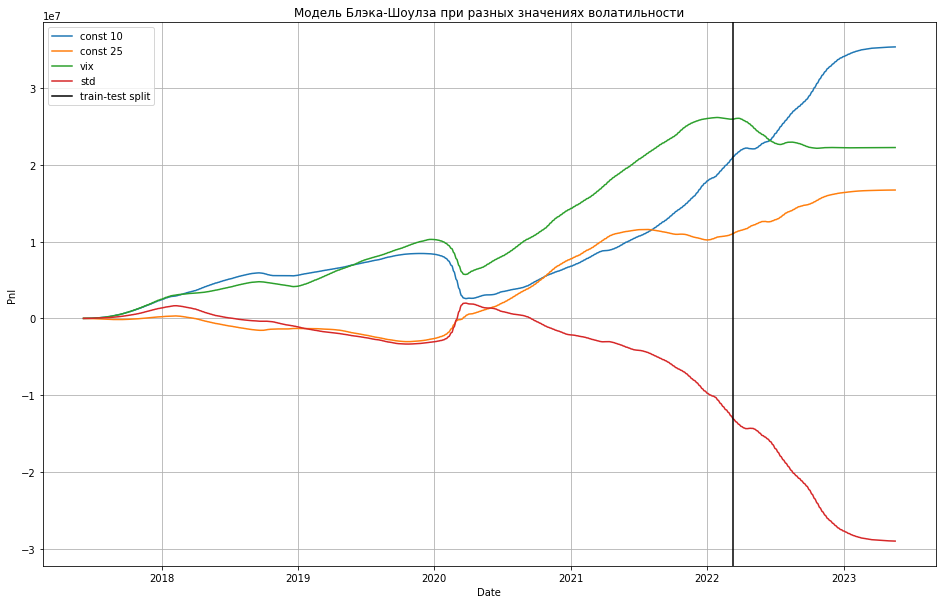

In [83]:
pnl_bs_10, trade_value_bs = run_backtest(signals_b_s_10, options_prices.Ask.values, options_prices.Bid.values, options_prices.OptExp.values, options_prices.Date.values, tnx_closest_index, exp_closest_index)
pnl_bs_25, trade_value_bs = run_backtest(signals_b_s_25, options_prices.Ask.values, options_prices.Bid.values, options_prices.OptExp.values, options_prices.Date.values, tnx_closest_index, exp_closest_index)
pnl_bs_vix, trade_value_bs = run_backtest(signals_b_s_vix, options_prices.Ask.values, options_prices.Bid.values, options_prices.OptExp.values, options_prices.Date.values, tnx_closest_index, exp_closest_index)
pnl_bs_std, trade_value_bs = run_backtest(signals_b_s_std, options_prices.Ask.values, options_prices.Bid.values, options_prices.OptExp.values, options_prices.Date.values, tnx_closest_index, exp_closest_index)
plt.figure(figsize=(16,10))
plt.plot(pd.to_datetime(tnx.index.values[tnx_closest_index[0]:exp_closest_index[-1]], unit="s"),pnl_bs_10, label= "const 10")
plt.plot(pd.to_datetime(tnx.index.values[tnx_closest_index[0]:exp_closest_index[-1]], unit="s"),pnl_bs_25, label= "const 25")
plt.plot(pd.to_datetime(tnx.index.values[tnx_closest_index[0]:exp_closest_index[-1]], unit="s"),pnl_bs_vix, label= "vix")
plt.plot(pd.to_datetime(tnx.index.values[tnx_closest_index[0]:exp_closest_index[-1]], unit="s"),pnl_bs_std, label= "std")
plt.axvline(pd.to_datetime(tnx.index.values[tnx_closest_index[0]:exp_closest_index[-1]][1200], unit="s"), label= "train-test split", color = "black")
# plt.ylim(0, 10000)
plt.title("Модель Блэка-Шоулза при разных значениях волатильности")
plt.legend()
plt.ylabel("Pnl")
plt.xlabel("Date")
plt.grid()
plt.show()

In [75]:
print(calc_sharpe(pnl_bs_10[:1200]))
print(calc_sharpe(pnl_bs_25[:1200]))
print(calc_sharpe(pnl_bs_vix[:1200]))
print(calc_sharpe(pnl_bs_std[:1200]))

16.11186911859756

In [79]:
print((pnl_bs_10[1200]))
print((pnl_bs_25[1200]))
print((pnl_bs_vix[1200]))
print((pnl_bs_std[1200]))

21065420.32261849
11080310.344425863
25965464.16414185
-13100457.447588496


In [80]:
print(calc_sharpe(pnl_bs_10[1200:] - int(pnl_bs_10[1200])) )
print(calc_sharpe(pnl_bs_25[1200:] - int(pnl_bs_25[1200])))
print(calc_sharpe(pnl_bs_vix[1200:] - int(pnl_bs_vix[1200])))
print(calc_sharpe(pnl_bs_std[1200:] - int(pnl_bs_std[1200])))

23.078560927343776
21.528906580334485
-9.408224644843534
-24.470292657209438


In [81]:
print((pnl_bs_10[-1] - pnl_bs_10[1200]))
print((pnl_bs_25[-1] - pnl_bs_25[1200]))
print((pnl_bs_vix[-1] - pnl_bs_vix[1200]))
print((pnl_bs_std[-1] - pnl_bs_std[1200]))

14306563.363994066
5645559.670771696
-3704698.163352579
-15914177.480137639


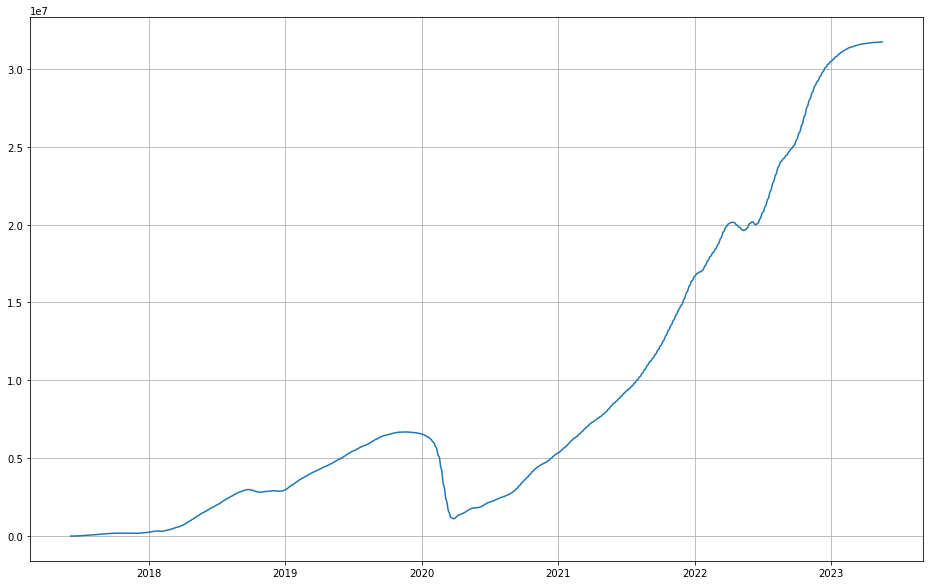

In [51]:
pnl_binomial, trade_value_binomial = run_backtest(signals_binomial, options_prices.Ask.values, options_prices.Bid.values, options_prices.OptExp.values, options_prices.Date.values, tnx_closest_index, exp_closest_index)
plt.figure(figsize=(16,10))
plt.plot(pd.to_datetime(tnx.index.values[tnx_closest_index[0]:exp_closest_index[-1]], unit="s"),pnl_binomial)
# plt.ylim(0, 10000)
plt.grid()
plt.show()